# 인물사진 프로젝트

In [ ]:
# 진행 결과

# 후기

이 또한 고통스러우리라       
아니 왜 자꾸 메모리에서 out of memory가 나오는거지..?!        
뭔 두번만 돌리면 바로 끝이여!!          
덕분에 계속 sudo kill - (PID 넘버) PID. 하면서 커널을 죽이고 다시 키는데          
좀 더 스마트한 방법이 있다면 알려주오.. (jupyter shutdown 제외)         

### 해결하지 못한 문제
1. **인물 주변이 매끄럽게 잘리지 않아 티가 남**   
가장 문제가 되었던 것은 주변 배경과 미묘하게 다르게, 잘린 티가 난다는 것!!          
거리를 조정해야하는지 색을 자를 때 색을 조정해야하는지...          
너무 고통스럽다!!         
<br>
2. **resize한 크기가 기존 이미지와 크기 차이가 존재함**   
그 다음으로 문제가 되었던 것은 이미지를 다시 크게 만들어주는 과정에서     
동일한 크기로 만들어지지 않은 것!!     
후... 이건 코드를 고치면 할 수 있을 거 같은데, 어떤 코드를 고쳐야 하는지 아직 못 찾았다.   
<br>
3. **솔루션 제시를 못함**    
이미지에서 어떤 문제점이 있는지는 파악할 수 있지만, 이를 해결하진 못함.   
해결하려면 내공이 필요하다..!!!

# 고려해야할 사항 

1. 인물모드 사진을 성공적으로 제작하였다.
    * 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
<br><br>
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    * 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
<br><br>
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    * 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.
    
    
    
# 진행순서

1. 사진 불러오기
2. 세그멘테이션 함수 설정
3. 세그멘테이션 진행
4. 문제점 파악 및 수정

In [1]:
# 한 번 해봅시다!! 
# 첫 빠따는 역시 짐승이지!!
## 고양이 모드다.

In [1]:
# 메모리가 자꾸 나간다면?

# # status initialize
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 초기화할 GPU number

# # out of memory
# import tensorflow as tf
# with tf.Graph().as_default():
#     gpu_options = tf.GPUOptions(allow_growth=True)


# gpus = tf.config.experimental.list_physical_devices('GPU') 
# if gpus: 
#     try: # Currently, memory growth needs to be the same across GPUs 
#         for gpu in gpus: 
#             tf.config.experimental.set_memory_growth(gpu, True) 
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
#     except RuntimeError as e: 
#         # Memory growth must be set before GPUs have been initialized 
#         print(e)

###################################################################################

# 위의 방법을 계속 실행해도 메모리가 나간다.
# sudo kill - (PID 넘버) PID  무한 반복중


In [1]:
# 기본 패키지 설정!
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 불러올 이미지 주소 설정
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(333, 500, 3)


In [3]:
# 세그멘테이션 모델을 만들어봅시다.

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# 사전에 학습된 가중치를 불러옵니다

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [73]:
# 준비한 이미지를 네트워크에 입력합니다.

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

# 고양이 파일로 했을 때는 고양이가 아니라 9(chair) 가 나온다..
# 고양이2 파일로 했을 때 8(cat)로 제대로 나온다.


(333, 500, 3) (341, 513, 3) 8


In [74]:
# 출력된 결과에서 seg_map.max()의 의미를 알아봅시다.

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

# background를 제외하면 20개 라벨

21

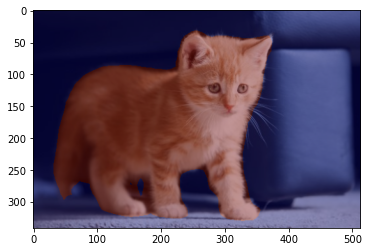

In [75]:
# 고양이만 추출해봅시다! == 라벨이 15인 것만 추출해봅시다!!

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

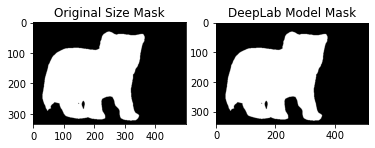

In [78]:
# resize 했던 이미지를 원래 크기로 만들어봅시다.
# 세그멘테이션 마스크를 원래 크기로!!

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # shape[:2][::-1]
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # 128을 바꾸면 고양이가 안잘려..

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

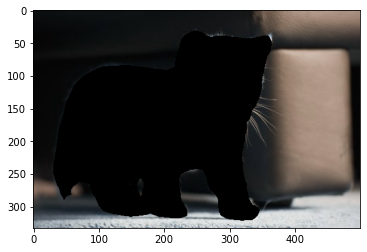

In [44]:
# 세그멘테이션 마스크를 이용해 배경만 추출해보자!!

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

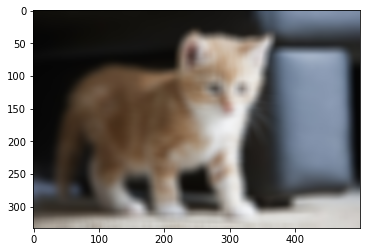

In [42]:
# 여기에 블러처리를 해서 배경을 흐리게 만들자!!

img_bg_blur = cv2.blur(img_bg, (15,15))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

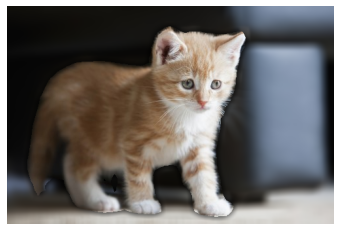

In [39]:
# 따로 빼두었던 마스크를 블러처리된 배경에 넣어보자

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.savefig("./human_segmentation/images/고양고양수정3.jpg")
plt.show()

In [ ]:
# 약간 어색한 느낌이 있다.

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./human_segmentation/images/고양이2.jpg">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="./human_segmentation/images/고양고양수정3.jpg">
</div>

In [ ]:
## 여기서부터는 배경바꾸기 입니다.

In [5]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/박성준배경1.jpg'  # 인물 추출로 쓸 사진입니다!
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/배경.jpg'  # 배경으로 쓸 사진입니다! 
img_orig2 = cv2.imread(img_path2) 
print (img_orig2.shape)

(1110, 1700, 3)
(1110, 1700, 3)


In [6]:
# 준비한 이미지를 네트워크에 입력합니다.

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1110, 1700, 3) (334, 513, 3) 15


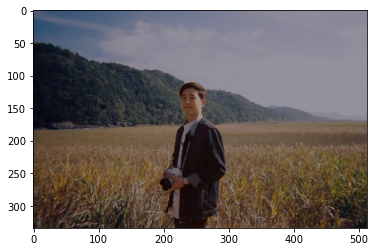

In [7]:
# 사람만 추출해봅시다! == 라벨이 15인 것만 추출해봅시다!!

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)            # 사람에 색을 칠한다?!
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.1, 0.0) # 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

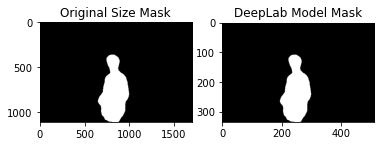

In [8]:
# resize 했던 이미지를 원래 크기로 만들어봅시다.
# 세그멘테이션 마스크를 원래 크기로!!

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # 128은 임계값

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

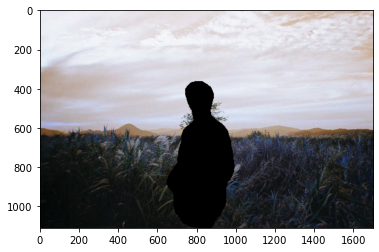

In [9]:
# 세그멘테이션 마스크를 이용해 배경만 추출해보자!!

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)


img_bg = cv2.bitwise_and(img_orig2, img_bg_mask)
plt.imshow(img_bg)
plt.show()

In [13]:
# 여기에 블러처리는 생략합니다.

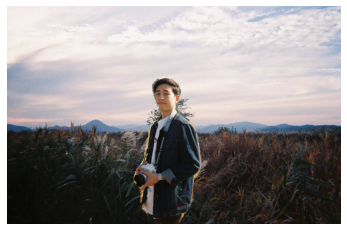

In [10]:
# 따로 빼두었던 마스크를 블러처리된 배경에 넣어보자

img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.savefig("./human_segmentation/images/배경바꾸기.jpg")
plt.show()

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./human_segmentation/images/박성준배경1.jpg">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="./human_segmentation/images/배경바꾸기.jpg">
</div>

## 인물사진으로 해봅시다.

In [14]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/박성준배경3.jpg'  # 인물 추출로 쓸 사진입니다!
img_orig = cv2.imread(img_path) 
print (img_orig.shape)


(2698, 3598, 3)


In [15]:
# 준비한 이미지를 네트워크에 입력합니다.

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

# 고양이 파일로 했을 때는 고양이가 아니라 9(chair) 가 나온다..
# 고양이2 파일로 했을 때 8(cat)로 제대로 나온다.

(2698, 3598, 3) (384, 513, 3) 15


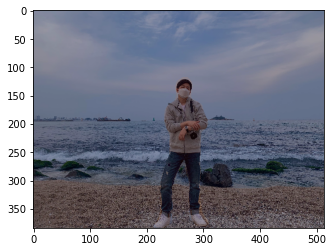

In [16]:
# 사람만 추출해봅시다! == 라벨이 15인 것만 추출해봅시다!!

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)            # 사람에 색을 칠한다?!
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.1, 0.0) # 

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

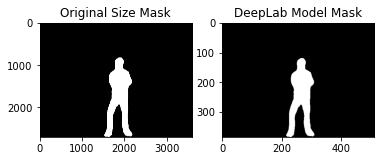

In [17]:
# resize 했던 이미지를 원래 크기로 만들어봅시다.
# 세그멘테이션 마스크를 원래 크기로!!

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # 128은 임계값

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

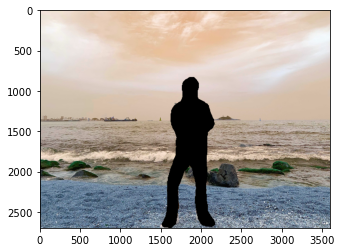

In [20]:
# 세그멘테이션 마스크를 이용해 배경만 추출해보자!!

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

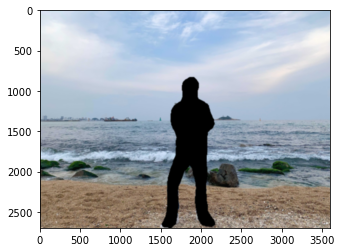

In [21]:
# 여기에 블러처리를 해서 배경을 흐리게 만들자!!

img_bg_blur = cv2.blur(img_bg, (15,15))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

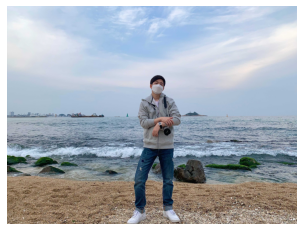

In [23]:
# 따로 빼두었던 마스크를 블러처리된 배경에 넣어보자

img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.savefig("./human_segmentation/images/배경바꾸기2.jpg")
plt.show()

<div style="width:48%; height:48%; float:left; margin-right:10px;">
<img src="./human_segmentation/images/박성준배경3.jpg">
</div>
<div style="width:48%; height:48%; float:left;">
<img src="./human_segmentation/images/배경바꾸기2.jpg">
</div>